In [1]:
import os 
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0" # "0,1,2,3" # "0"

In [2]:
import numpy as np
import h5py
import cv2
import os, sys, gc
import argparse
from glob import glob
from core.get_args import get_args
from core.produce_denoised_img import produce_denoised_img_no_crop
from core.utils import TedataLoader
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from core.watershed import watershed,watershed_per_img,watershed_original
from core.median_filter import apply_median_filter_cpu, apply_median_filter_gpu, apply_median_filter_gpu_simple
%load_ext autoreload
%autoreload 2

# Denoising SET1~10 image with FBI-denoiser


In [8]:
!ls ../data/Samsung+SNU+dataset+230216/\[SET\ 1-1\]/F8

10_F8.png  16_F8.png  21_F8.png  27_F8.png  32_F8.png  38_F8.png  4_F8.png
11_F8.png  17_F8.png  22_F8.png  28_F8.png  33_F8.png  39_F8.png  5_F8.png
12_F8.png  18_F8.png  23_F8.png  29_F8.png  34_F8.png  3_F8.png   6_F8.png
13_F8.png  19_F8.png  24_F8.png  2_F8.png   35_F8.png  40_F8.png  7_F8.png
14_F8.png  1_F8.png   25_F8.png  30_F8.png  36_F8.png  41_F8.png  8_F8.png
15_F8.png  20_F8.png  26_F8.png  31_F8.png  37_F8.png  42_F8.png  9_F8.png


In [10]:
args = get_args()
args.pge_weight_dir = None #pge_weight_dir
args.loss_function = "MSE_Affine"
args.noise_type = 'Poisson-Gaussian'
args.model_type = 'FBI_Net'
# args.set_num = '1'
args.data_name = 'Samsung'
args.data_type = 'Grayscale'
args.lr = 0.001
args.num_layers = 17
args.num_filters = 64
# args.crop_size = 200
args.debug = False
args

Namespace(date='', seed=0, noise_type='Poisson-Gaussian', loss_function='MSE_Affine', model_type='FBI_Net', data_type='Grayscale', data_name='Samsung', nepochs=50, batch_size=4, lr=0.001, drop_rate=0.5, drop_epoch=10, crop_size=120, alpha=0.01, beta=0.02, num_layers=17, num_filters=64, mul=1, unet_layer=3, pge_weight_dir=None, output_type='sigmoid', sigmoid_value=0.1, use_other_target=False, x_f_num='F1', y_f_num='F64', integrate_all_set=False, set_num=1, test=False, train_with_MSEAffine=False, debug=False)

In [11]:
fbi_weight_dir = glob("../weights/230207_FBI_Net*")[0] # RN2N F08

(2048, 3072)
(1, 1, 1436, 3072)


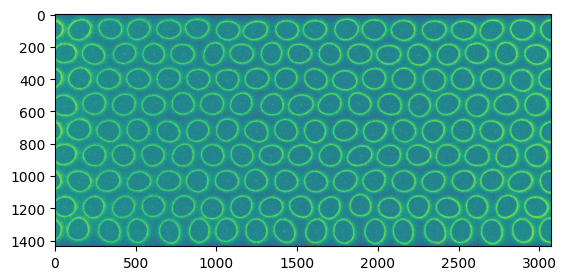

In [24]:
path = "../data/Samsung_tmp_dataset/Samsung+SNU+dataset+230216/[SET 4-1]/F16/1_F16.png"
import PIL
# a = np.array(PIL.Image.open(path))# [256:-256]
a = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
print(a.shape)
a = a[306:-306]
plt.imshow(a)
img = np.expand_dims(a,axis=0)
img = np.expand_dims(img,axis=0)/255.

print(img.shape)

In [22]:
img.dtype, img.min(), img.max()

(dtype('uint8'), 0, 255)

In [23]:
# img = np.expand_dims(img_dict['SET1-1']['F08'][0],axis=0)
# # img = np.expand_dims(img,axis=0)

# img.dtype, img.min(), img.max()

(dtype('float64'), 0.0, 1.0)

230207_FBI_Net_Grayscale_Samsung_SET050607080910_mixed_x_as_F#_y_as_F08_MSE_Affine_layers_x17_filters_x64_cropsize_256.w
F08 v2


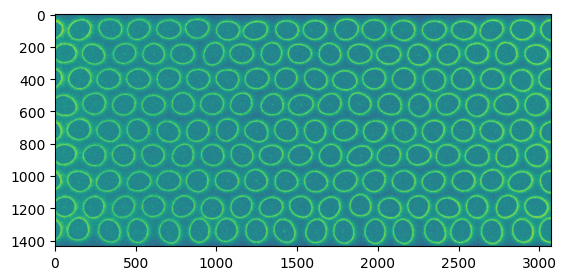

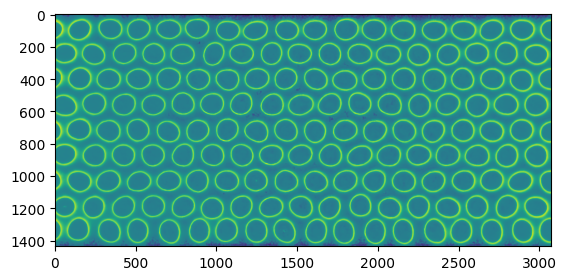

In [26]:
img_patch = img#[:,:,256:512,256:512] #[:,:,200:456,:256]
for fbi_weight_dir in glob("../weights/230207_FBI_Net*"):
    print(fbi_weight_dir.split('/')[-1])
    target_y = fbi_weight_dir.split("_y_as_")[1][:3]
    dataset_version = 'v1' if "with" in fbi_weight_dir else 'v2'
    print(target_y, dataset_version)
    model = produce_denoised_img_no_crop(_pge_weight_dir=None,_fbi_weight_dir = fbi_weight_dir,_args = args)

    plt.imshow(img_patch[0][0])
    plt.pause(0.01)
    img_patch_out = model.eval(img_patch)
    plt.imshow(img_patch_out[0][0])
    plt.pause(0.01)
    break

## Load original img
with 0~1 scale

In [7]:
!ls ../data/Samsung+SNU+dataset+230216_1536x3072_aligned

SET1-1	SET2-1	SET3-1	SET4-1


In [8]:

img_dict = {}
debug = False
# data_path = "/mnt/ssd/hyun/fbi-net/FBI-Denoiser/data/Samsung_SNU_1474x3010_aligned_ordered/" 
for data_path in glob("/mnt/ssd/hyun/fbi-net/FBI-Denoiser/data/Samsung+SNU+dataset+230216_1536x3072_aligned"):
    print(data_path)
    for set_num in sorted(os.listdir(data_path)):
        if set_num[0] == '.' :
            continue
        img_dict[set_num] = {}
        # if debug is True:
        #     print(set_num)
        set_path = os.path.join(data_path,set_num)
        img_list = sorted(os.listdir(set_path))
        img_list = list(filter(lambda x : ".ipynb_checkpoints" not in x,img_list))
        f_num_list = np.array(list(map(lambda x : x.split('_')[0],img_list)))
        f_num_list = np.unique(f_num_list)
        for f_num in f_num_list:
            img_dict[set_num][f_num] = None
        # if debug is True:
        #     print(img_list)
        #     print(f_num_list)


        for img_path in sorted(img_list):
            f_num = img_path.split("_")[0]

            img_path = os.path.join(set_path,img_path)
            if debug is True:
                print(f_num," & ",img_path)
            img = cv2.imread(img_path,cv2.IMREAD_GRAYSCALE)
            # img_dict[set_num][f_num].append(img)
            img = np.expand_dims(img,axis=0)
            img = np.expand_dims(img,axis=0)/255.
            if img_dict[set_num][f_num] is None:  
                img_dict[set_num][f_num] = img
            else :
                img_dict[set_num][f_num] = np.append(img_dict[set_num][f_num],img,axis=0)
            if debug is True:
                print(set_num,f_num,img.shape)


/mnt/ssd/hyun/fbi-net/FBI-Denoiser/data/Samsung+SNU+dataset+230216_1536x3072_aligned


In [9]:
print(img_dict.keys())
for set_num in img_dict.keys():
    print(img_dict[set_num].keys())
    for f_num in img_dict[set_num].keys():
        print(img_dict[set_num][f_num].shape)

dict_keys(['SET1-1', 'SET2-1', 'SET3-1', 'SET4-1'])
dict_keys(['F08', 'F16', 'F32', 'F64'])
(42, 1, 1454, 2990)
(42, 1, 1454, 2990)
(42, 1, 1454, 2990)
(42, 1, 1454, 2990)
dict_keys(['F08', 'F16', 'F32', 'F64'])
(42, 1, 1454, 2990)
(42, 1, 1454, 2990)
(42, 1, 1454, 2990)
(42, 1, 1454, 2990)
dict_keys(['F08', 'F16', 'F32', 'F64'])
(42, 1, 1454, 2990)
(42, 1, 1454, 2990)
(42, 1, 1454, 2990)
(42, 1, 1454, 2990)
dict_keys(['F08', 'F16', 'F32', 'F64'])
(42, 1, 1454, 2990)
(42, 1, 1454, 2990)
(42, 1, 1454, 2990)
(42, 1, 1454, 2990)


In [10]:
args = get_args()
args.pge_weight_dir = None #pge_weight_dir
args.loss_function = "MSE_Affine"
args.noise_type = 'Poisson-Gaussian'
args.model_type = 'FBI_Net'
# args.set_num = '1'
args.data_name = 'Samsung'
args.data_type = 'Grayscale'
args.lr = 0.001
args.num_layers = 17
args.num_filters = 64
# args.crop_size = 200
args.debug = False
args

Namespace(date='', seed=0, noise_type='Poisson-Gaussian', loss_function='MSE_Affine', model_type='FBI_Net', data_type='Grayscale', data_name='Samsung', nepochs=50, batch_size=4, lr=0.001, drop_rate=0.5, drop_epoch=10, crop_size=120, alpha=0.01, beta=0.02, num_layers=17, num_filters=64, mul=1, unet_layer=3, pge_weight_dir=None, output_type='sigmoid', sigmoid_value=0.1, use_other_target=False, x_f_num='F1', y_f_num='F64', integrate_all_set=False, set_num=1, test=False, train_with_MSEAffine=False, debug=False)

In [11]:
fbi_weight_dir = glob("../weights/230207_FBI_Net*")[0] # RN2N F08

In [14]:
img = np.expand_dims(img_dict['SET1-1']['F08'][0],axis=0)
# img = np.expand_dims(img,axis=0)

print(img.shape)

(1, 1, 1454, 2990)


230207_FBI_Net_Grayscale_Samsung_SET050607080910_mixed_x_as_F#_y_as_F08_MSE_Affine_layers_x17_filters_x64_cropsize_256.w
F08 v2


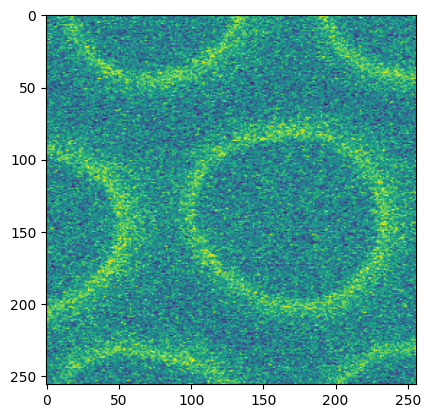

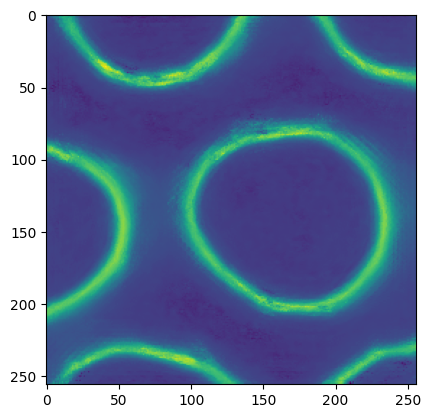

230207_FBI_Net_Grayscale_Samsung_SET050607080910_with_SET01020304_mixed_x_as_F#_y_as_F16_MSE_Affine_layers_x17_filters_x64_cropsize_256.w
F16 v1


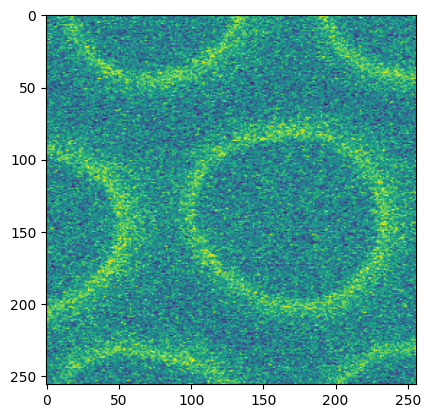

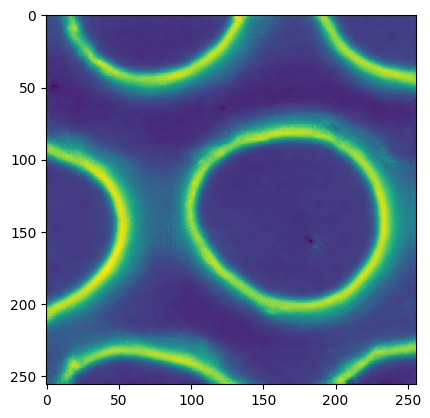

230207_FBI_Net_Grayscale_Samsung_SET050607080910_mixed_x_as_F#_y_as_F04_MSE_Affine_layers_x17_filters_x64_cropsize_256.w
F04 v2


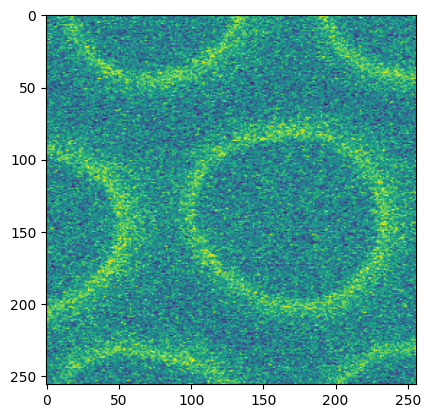

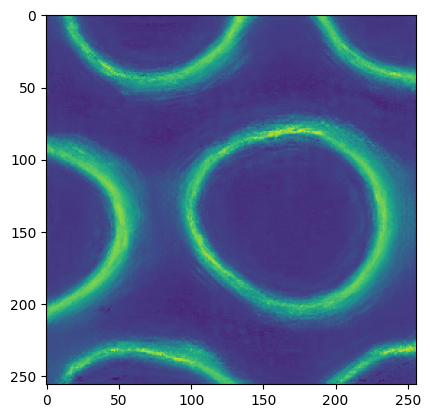

230207_FBI_Net_Grayscale_Samsung_SET050607080910_mixed_x_as_F#_y_as_F16_MSE_Affine_layers_x17_filters_x64_cropsize_256.w
F16 v2


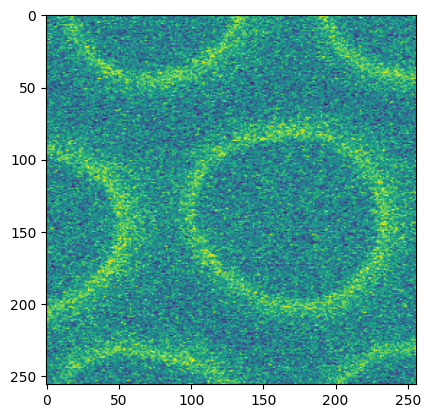

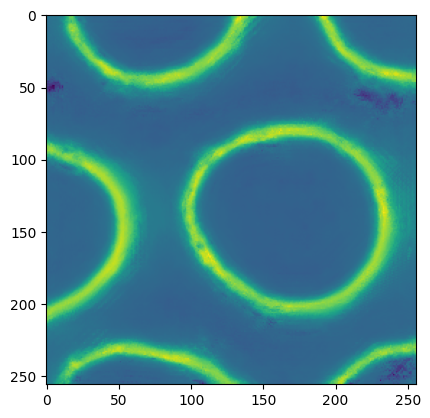

230207_FBI_Net_Grayscale_Samsung_SET050607080910_mixed_x_as_F#_y_as_F02_MSE_Affine_layers_x17_filters_x64_cropsize_256.w
F02 v2


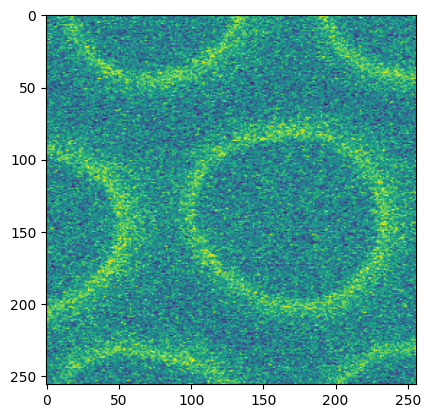

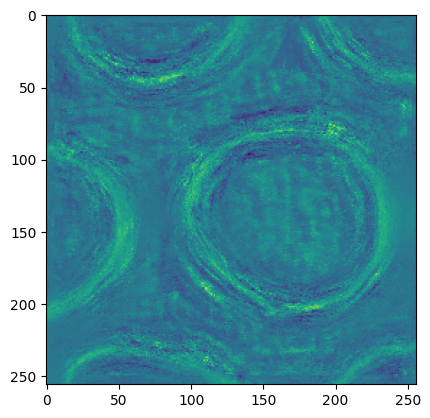

In [16]:
img_patch = img[:,:,256:512,256:512] #[:,:,200:456,:256]
for fbi_weight_dir in glob("../weights/230207_FBI_Net*"):
    print(fbi_weight_dir.split('/')[-1])
    target_y = fbi_weight_dir.split("_y_as_")[1][:3]
    dataset_version = 'v1' if "with" in fbi_weight_dir else 'v2'
    print(target_y, dataset_version)
    model = produce_denoised_img_no_crop(_pge_weight_dir=None,_fbi_weight_dir = fbi_weight_dir,_args = args)

    plt.imshow(img_patch[0][0])
    plt.pause(0.01)
    img_patch_out = model.eval(img_patch)
    plt.imshow(img_patch_out[0][0])
    plt.pause(0.01)

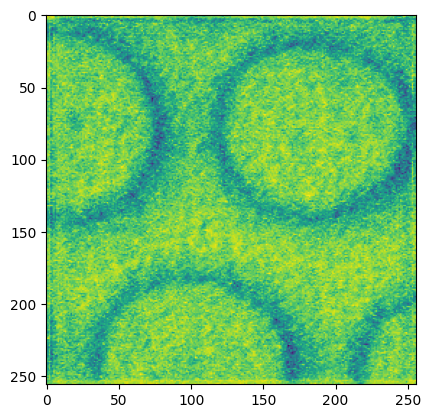

In [24]:

patch_out = model.eval(img[:,:,200:456,:256])
plt.imshow(patch_out[0][0])

In [42]:
debug= True

for fbi_weight_dir in glob("../weights/230207_FBI_Net*"):
    target_y = fbi_weight_dir.split("_y_as_")[1][:3]
    dataset_version = 'v1' if "with" in fbi_weight_dir else 'v2'
    if debug is True:
        print(fbi_weight_dir)
    print("======",target_y,dataset_version,"======")
    folder_name = f"./denoised_img_{target_y}_{dataset_version}"
    os.makedirs(folder_name,exist_ok=True)
    model = produce_denoised_img_no_crop(_pge_weight_dir=None,_fbi_weight_dir = fbi_weight_dir,_args = args)
    
    # DENOISE IMAGE
    denoised_img_dict = {}
    for set_num in img_dict.keys():
        denoised_img_dict[set_num] = {}
        for f_num in img_dict[set_num].keys():
            denoised_img_dict[set_num][f_num] = None
            for img in img_dict[set_num][f_num]:
                img = np.expand_dims(img, axis=0) # (1,1,1474,3010)
                print(img.shape,img.min(),img.max())
                denoised_img = model.eval(img)
                if denoised_img_dict[set_num][f_num] is None:
                    denoised_img_dict[set_num][f_num] = denoised_img
                else :
                    denoised_img_dict[set_num][f_num] = np.append(denoised_img_dict[set_num][f_num], denoised_img,axis=0)

            print(f"Denoising SET : {set_num}, f_num : {f_num} End")
            sys.exit(-1)
    # SAVE IMG
    print(denoised_img_dict.keys())
    for set_num in denoised_img_dict.keys():
        print(denoised_img_dict[set_num].keys())
        os.makedirs(f"{folder_name}/{set_num}", exist_ok=True)
        for f_num in denoised_img_dict[set_num].keys():
            # print(denoised_img_dict[set_num][f_num].shape)
            filename = f"{folder_name}/{set_num}/{f_num}.npy"
            np.save(filename, denoised_img_dict[set_num][f_num])
            # for idx,img in enumerate(denoised_img_dict[set_num][f_num]):
            #     filename = f"{folder_name}/{set_num}/{f_num}_{idx:02d}.png"
            #     img = (img*255).astype('uint8')
            #     cv2.imwrite(filename, img[0])
            print(f"Saving SET : {set_num}, f_num : {f_num} End")
    del model,denoised_img_dict
    gc.collect()


../weights/230207_FBI_Net_Grayscale_Samsung_SET050607080910_mixed_x_as_F#_y_as_F08_MSE_Affine_layers_x17_filters_x64_cropsize_256.w
====== F08 v2 ======
(1, 1, 1474, 3010) 0.0 1.0
(1, 1, 1474, 3010) 0.0 1.0
(1, 1, 1474, 3010) 0.0 1.0
(1, 1, 1474, 3010) 0.0 1.0
(1, 1, 1474, 3010) 0.0 1.0
(1, 1, 1474, 3010) 0.0 1.0
(1, 1, 1474, 3010) 0.0 1.0
(1, 1, 1474, 3010) 0.0 1.0
(1, 1, 1474, 3010) 0.0 1.0
(1, 1, 1474, 3010) 0.0 1.0
(1, 1, 1474, 3010) 0.0 1.0
(1, 1, 1474, 3010) 0.0 1.0
(1, 1, 1474, 3010) 0.0 1.0
(1, 1, 1474, 3010) 0.0 1.0
(1, 1, 1474, 3010) 0.0 1.0
(1, 1, 1474, 3010) 0.0 1.0
Denoising SET : SET01, f_num : F08 End


SystemExit: -1

(1474, 3010) -1.7194686 245.86078


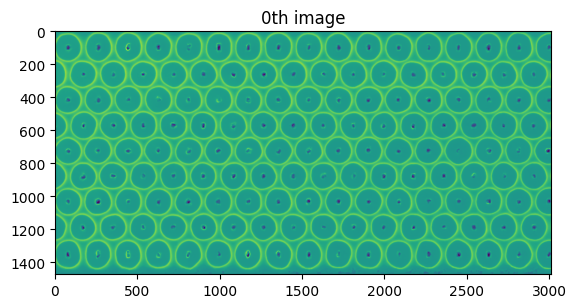

In [43]:
# denoised_img_dict['SET01']['F08'].shape
index = 0
for index in range(16):
    plt.title(f"{index}th image")
    img = denoised_img_dict['SET01']['F08'][index][0] * 255
    # img = (img - img.min())/(img.max()-img.min())
    print(img.shape,img.min(),img.max())
    plt.imshow(img)
    plt.pause(0.01)
    break

0



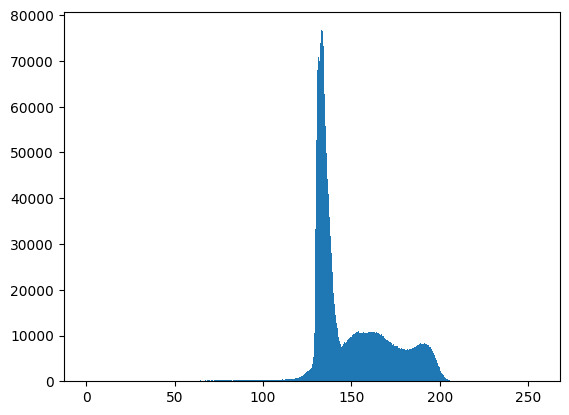

In [50]:
print(index)
bins= np.linspace(0,255,1000)
plt.hist(bins=bins,x=(img).flatten())
print("")

In [53]:
np.max(img),np.argmax(img)

(245.86078, 343576)